In [18]:

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import os as os
import random
import multiprocessing
from joblib import Parallel, delayed

import pywt
from pywt._extensions._pywt import (DiscreteContinuousWavelet, ContinuousWavelet,
                                Wavelet, _check_dtype)
from pywt._functions import integrate_wavelet, scale2frequency
from time import time as ti
import datetime


import platform

HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
    

if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/CraneData/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "SmallCopy\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "SmallCopy\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'SmallCopy/'
    

scales = 500
#img_height , img_width = scales, 200
DoSomeFiles = True
NumberOfFiles = 5
SmoothType = 3  # 0 = none, 1 = rolling average, 2 = rolling StdDev
TrainEpochs = 3
WaveletToUse = 'beta'

num_cores = multiprocessing.cpu_count() -1
SensorPositonFile = rootfolder + 'SensorStatsSmall.csv'

if Computer == "SciClone" or Computer == "LinLap":
    SaveModelFolder = rootfolder + 'SavedModel/'
else:
    SaveModelFolder = rootfolder + 'SavedModel\\'

files = os.listdir(folder)
if DoSomeFiles: files = random.sample(files,NumberOfFiles)

OutputVectors = np.genfromtxt(open(SensorPositonFile,'r'), delimiter=',',skip_header=1,dtype=int, missing_values=0)

In [19]:
import CoreFunctions as cf

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
AllAccels = Parallel(n_jobs=num_cores)(delayed(cf.getAcceleration)(file) for file in files)
Flattened = []
for j in range(np.shape(AllAccels)[0]):
    if AllAccels[j][0] == False:
        print(j,AllAccels[j][1])
    else: 
        Flattened.append(AllAccels[j])
print('Have Data')

Have Data


In [22]:
MetaData = []  #np.asarray([],dtype=object)
DataOnlyMatrix = np.asarray([],dtype=object)
for j in range(np.shape(AllAccels)[0]):
    if AllAccels[j][0] == False :
        if AllAccels[j][1][4:9] =='Accel':
            print(j,AllAccels[j][1])
    else: 
        for k in range(3):
            MetaData.append([AllAccels[j][k][0], AllAccels[j][k][1], AllAccels[j][k][3], AllAccels[j][k][4]])
            if np.size(DataOnlyMatrix) == 0:
                    DataOnlyMatrix =np.matrix(AllAccels[j][k][2])
            else:
                    DataOnlyMatrix = np.concatenate((DataOnlyMatrix,np.matrix(AllAccels[j][k][2])),axis=0)

MetaData = np.matrix(MetaData)

In [23]:
AllAccels = cf.KalmanGroup(DataOnlyMatrix)

In [24]:
maxes = np.amax(AllAccels[:,500:], axis = 1)
mins = np.amin(AllAccels[:,500:], axis = 1)

Keep = np.zeros(mins.size)
for i in range(mins.size):
    if i % 3 == 0:
        if maxes[i] > 0.01 and mins[i] < -0.01:
            Keep[i]=1
            Keep[i+1]=1
            Keep[i+2]=1
            #print(i)
            

Keep = np.array(Keep, dtype='bool')
            
AllAccels = AllAccels[Keep,:]
MetaData = MetaData[Keep,:]

In [25]:
MotionsLeft = int(np.shape(AllAccels)[0]/3.0)

In [26]:
AllFingers =  Parallel(n_jobs=num_cores)(delayed(cf.makeMatrixImages)([AllAccels[i*3],AllAccels[i*3+1],AllAccels[i*3+2]]) for i in range(MotionsLeft))

print('Have fingerprints')

Have fingerprints


In [27]:
sShape = np.shape(AllFingers)
length = sShape[0]
AllFingers = np.resize(AllFingers,(length, sShape[1]*sShape[2]*sShape[3]))
justifier = np.ones((length, np.shape(AllFingers)[1]))
mins = np.zeros(length)
maxes = np.zeros(length)
for i in range(length):
    mins[i]= np.min(AllFingers[i][:])
    maxes[i]= np.max(AllFingers[i][:])
justifier = justifier.T * mins.T
MadeImageRange = AllFingers - justifier.T
justifier = np.ones((length, np.shape(AllFingers)[1]))
rangeValues = maxes-mins
justifier = justifier.T * rangeValues.T
MadeImageRange = MadeImageRange / justifier.T
MadeImageRange = np.resize(MadeImageRange, sShape)

In [28]:
PlotWidthIn = 11
PlotHeightIn = 3.75
PlotDPI = 120

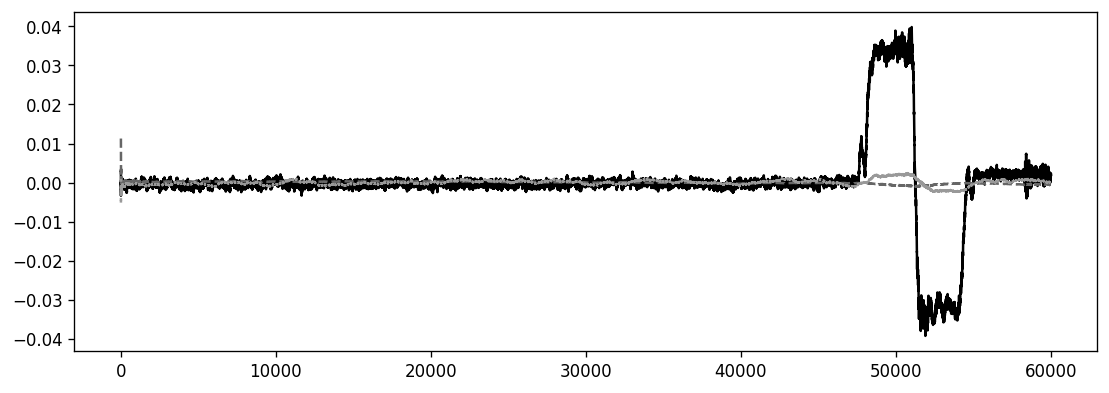

In [29]:
fig=plt.figure(figsize=(PlotWidthIn,PlotHeightIn),dpi=PlotDPI)
plt.plot(np.asarray(AllAccels[0]).flatten())
plt.plot(np.asarray(AllAccels[1]).flatten())
plt.plot(np.asarray(AllAccels[2]).flatten())
plt.show()

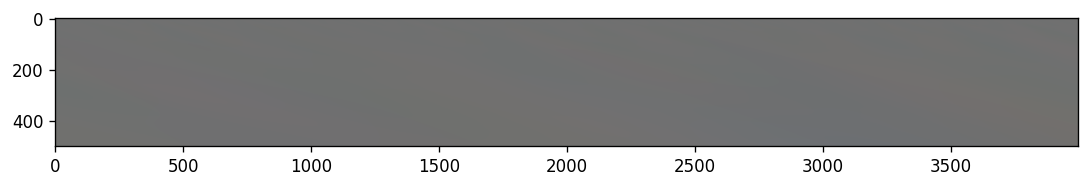

In [30]:

fig=plt.figure(figsize=(PlotWidthIn,PlotHeightIn),dpi=PlotDPI)
plt.imshow(MadeImageRange[0][:,8000:12000], interpolation='nearest')
plt.show()

In [31]:
numslices = 10

cfX = np.matrix(MadeImageRange[0][:,:][0])

cfX *= float(numslices +1)

cfX += 0.5

cfX = np.matrix(cfX, dtype=int)

cfX = np.mod(cfX, 2)

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (1, 3)

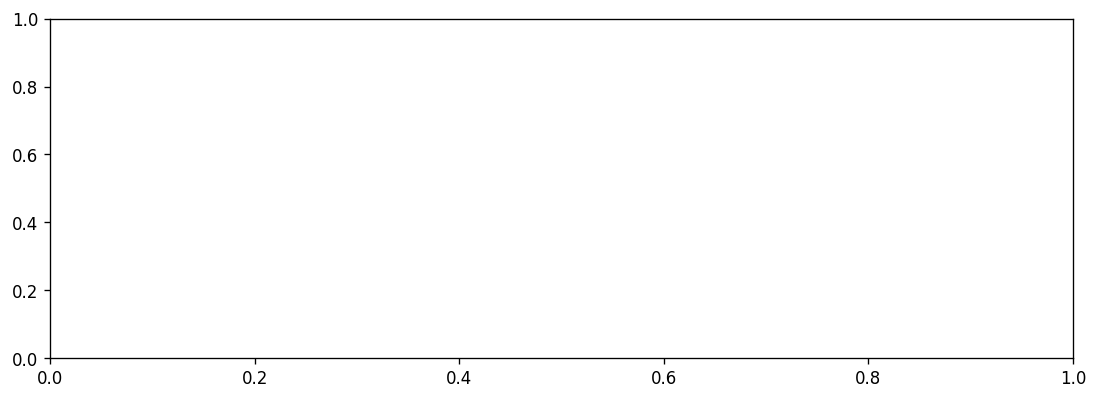

In [32]:
h = cf.PlotFingerPrint(cfX)

In [ ]:
AllFingers =  Parallel(n_jobs=num_cores)(delayed(cf.getThumbprint2)(AC) for AC in AllAccels)


In [ ]:
h = cf.PlotFingerPrint([AllFingers[0][20000:30000], 'Fingerprint of same'])